In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/CNN_dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: CNN_dataset/CXR/009317.jpeg  
  inflating: __MACOSX/CNN_dataset/CXR/._009317.jpeg  
  inflating: CNN_dataset/CXR/002808.jpeg  
  inflating: __MACOSX/CNN_dataset/CXR/._002808.jpeg  
  inflating: CNN_dataset/CXR/000835.jpeg  
  inflating: __MACOSX/CNN_dataset/CXR/._000835.jpeg  
  inflating: CNN_dataset/CXR/001727.jpeg  
  inflating: __MACOSX/CNN_dataset/CXR/._001727.jpeg  
  inflating: CNN_dataset/CXR/004525.jpeg  
  inflating: __MACOSX/CNN_dataset/CXR/._004525.jpeg  
  inflating: CNN_dataset/CXR/006518.jpeg  
  inflating: __MACOSX/CNN_dataset/CXR/._006518.jpeg  
  inflating: CNN_dataset/CXR/008855.jpeg  
  inflating: __MACOSX/CNN_dataset/CXR/._008855.jpeg  
  inflating: CNN_dataset/CXR/009747.jpeg  
  inflating: __MACOSX/CNN_dataset/CXR/._009747.jpeg  
  inflating: CNN_dataset/CXR/001377.jpeg  
  inflating: __MACOSX/CNN_dataset/CXR/._001377.jpeg  
  inflating: CNN_dataset/CXR/004175.jpeg  
  inflating: __MACOSX/CNN_dataset

In [3]:
import os

datasetsInfo = {}
rootDir = "CNN_dataset"
catagories = ['HeadCT', 'ChestCT', 'Hand', 'AbdomenCT', 'CXR']

for i in catagories:
  datasetsInfo[i] = len(os.listdir(rootDir + '/' + i))

print(datasetsInfo)

{'HeadCT': 10000, 'ChestCT': 10000, 'Hand': 10000, 'AbdomenCT': 10000, 'CXR': 10000}


In [4]:
import shutil
import random

for i in catagories:
  origDir = rootDir + '/' + i
  
  # ratio = [0.8, 0.5, 1]
  # split = ['train', 'test', 'val']
  ratio = [0.8, 1]
  split = ['train', 'test']

  for idx, s in enumerate(split):
    os.makedirs(s + '/' + i)

    lst = os.listdir(origDir)
    valList = random.sample(lst, k=round(len(lst) * ratio[idx]))

    for j in valList:
      shutil.move(origDir + '/' + j, s + '/' + i + '/' + j)

In [6]:
for i in catagories:
  print(
      len(os.listdir('train/' + i)),
      len(os.listdir('test/' + i))
      # len(os.listdir('val/' + i))
  )

8000 2000
8000 2000
8000 2000
8000 2000
8000 2000


In [22]:
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Dense, Flatten
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing.image import ImageDataGenerator

In [8]:
base_model = InceptionV3(input_shape=(256, 256, 3), include_top=False)

87910968/87910968 [==============================] - 4s 0us/step


In [9]:
for layer in base_model.layers:
  layer.trainable = False

In [10]:
X = Flatten()(base_model.output)
X = Dense(units=5, activation='sigmoid')(X)

# Final Model
model = Model(base_model.input, X)

model.compile(optimizer='adam',
            loss=keras.losses.binary_crossentropy,
            metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [11]:
train_datagen = ImageDataGenerator(
    featurewise_center=True,
    rotation_range=0.4,
    width_shift_range=0.3,
    horizontal_flip=True,
    preprocessing_function=preprocess_input,
    zoom_range=0.4,
    shear_range=0.4
)

train_data = train_datagen.flow_from_directory(
    directory="train",
    target_size=(256, 256),
    batch_size=128
)

Found 40000 images belonging to 5 classes.


In [12]:
train_data.class_indices

{'AbdomenCT': 0, 'CXR': 1, 'ChestCT': 2, 'Hand': 3, 'HeadCT': 4}

/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


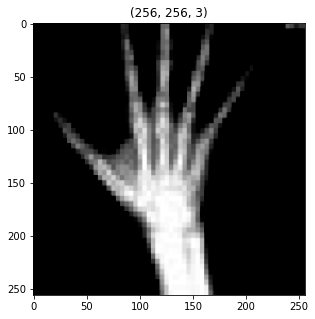

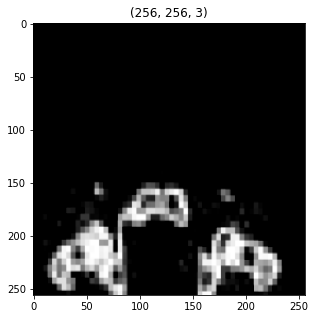

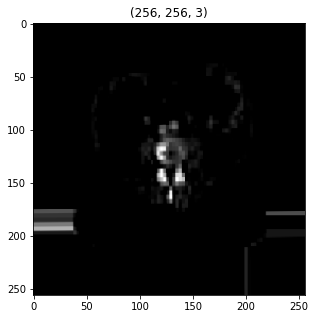

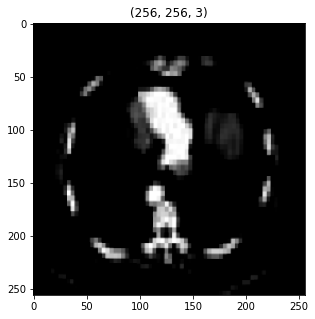

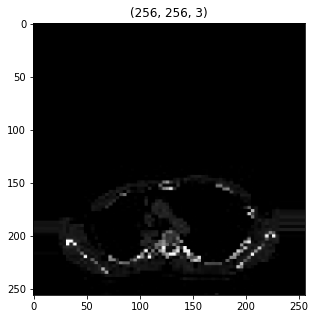

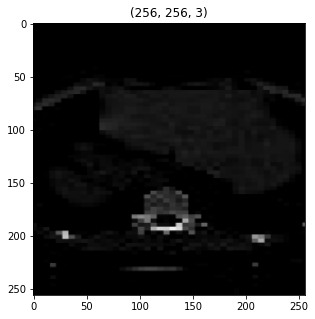

In [13]:
t_img, label = train_data.next()

def plotImages(img_arr, label):
  for idx, img in enumerate(img_arr):
    if idx <= 5:
      plt.figure(figsize=(5, 5))
      plt.imshow(img)
      plt.title(img.shape)
      plt.show()

plotImages(t_img, label)

In [14]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

mc = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='accuracy',
    verbose=1,
    save_best_only=True
)

es = EarlyStopping(
    monitor='accuracy',
    min_delta=0.1,
    patience=3,
    verbose=1
)

cb = [mc, es]

In [15]:
his = model.fit(
    train_data,
    steps_per_epoch=5,
    epochs=10,
    callbacks=cb
)

Epoch 1/10
5/5 [==============================] - ETA: 0s - loss: 3.1122 - accuracy: 0.2859
Epoch 1: accuracy improved from -inf to 0.28594, saving model to best_model.h5
5/5 [==============================] - 24s 2s/step - loss: 3.1122 - accuracy: 0.2859
Epoch 2/10
5/5 [==============================] - ETA: 0s - loss: 0.8074 - accuracy: 0.8156
Epoch 2: accuracy improved from 0.28594 to 0.81563, saving model to best_model.h5
5/5 [==============================] - 11s 2s/step - loss: 0.8074 - accuracy: 0.8156
Epoch 3/10
5/5 [==============================] - ETA: 0s - loss: 0.4020 - accuracy: 0.8547
Epoch 3: accuracy improved from 0.81563 to 0.85469, saving model to best_model.h5
5/5 [==============================] - 12s 2s/step - loss: 0.4020 - accuracy: 0.8547
Epoch 4/10
5/5 [==============================] - ETA: 0s - loss: 0.2595 - accuracy: 0.9094
Epoch 4: accuracy improved from 0.85469 to 0.90938, saving model to best_model.h5
5/5 [==============================] - 13s 3s/step -

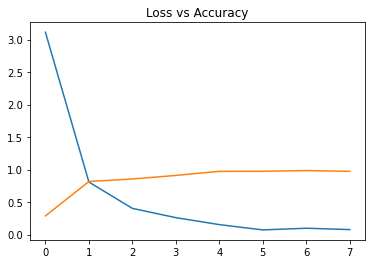

In [16]:
h = his.history
plt.plot(h['loss'])
plt.plot(h['accuracy'])

plt.title('Loss vs Accuracy')
plt.show()

1/1 [==============================] - 0s 33ms/step


Prediction true


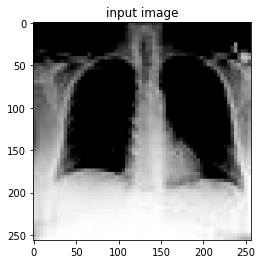

In [25]:
from keras.utils import load_img, img_to_array

path = '/content/test/CXR/000046.jpeg'
img = load_img(path, target_size=(256, 256))

i = preprocess_input(img_to_array(img))
input_arr = np.array([i])
input_arr.shape

pred = np.argmax(model.predict(input_arr))

if pred == 1:
  print('Prediction true')
else:
  print('Prediction false')

plt.imshow(input_arr[0])
plt.title('input image')
plt.show()